# Training SVM 

In [3]:
from svgClassifier import train

FILENAME = "model.p"
SAMPLE_SIZE = 10000
DATA_PATH = './data'

train(save=True, save_path=FILENAME, tuning=True, sample_size=SAMPLE_SIZE)
print("**Done**")

Using: YCrCb color space, 12 orientations, 8 pixels per cell, 2 and cells per block
Feature vector length: 7920
Tuning SVM parameters using GridSearchCV() with: 
	 {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10], 'kernel': ('linear', 'rbf')}
61670.33 Seconds to train SVM...
Saving trained model to: model.p
Test Accuracy of SVC = 0.9842
**Done**


# Training without Tuning

In [2]:
from svgClassifier import train

FILENAME = "model_no_spatial.p"
SAMPLE_SIZE = "ALL"
DATA_PATH = './data'

train(save=True, save_path=FILENAME, tuning=False, sample_size=SAMPLE_SIZE)
print("**Done**")

Number of car images: 8792
Number of non-car images 8968
Using: YCrCb color space, 12 orientations, 8 pixels per cell, 2 and cells per block
Feature vector length: 7152
196.86 Seconds to train SVM...
Saving trained model to: model_no_spatial.p
Test Accuracy of SVC = 0.962
**Done**


# Setting Different Window Scales Across the Image

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def setWindows(img, ystart, ystop, scale, window, pix_per_cell, cell_per_block, xy_cells_per_step):
    
    x_cells_per_step = xy_cells_per_step[0]
    y_cells_per_step = xy_cells_per_step[1]
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // x_cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // y_cells_per_step + 1
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*y_cells_per_step
            xpos = xb*x_cells_per_step

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            win_draw = np.int(window*scale)
            xbox_left = img.shape[1] - np.int(xleft*scale) - win_draw  - 1
            ytop_draw = np.int(ytop*scale)
            
            ybox_left = ytop_draw + ystart
            xbox_right = xbox_left + win_draw
            ybox_right = ytop_draw + win_draw + ystart

            if xbox_left < 0 or xbox_right < 0:
                continue
                
            if xbox_right >= img.shape[1]:
#                 xbox_right = img.shape[1] - 1
                continue
                
#             if ybox_right >= img.shape[0]:
#                 ybox_right = img.shape[0] - 1
#                 continue
            
                
            cv2.rectangle(draw_img,(xbox_left, ybox_left), (xbox_right, ybox_right) ,(100,50,255),6) 
                
    return draw_img

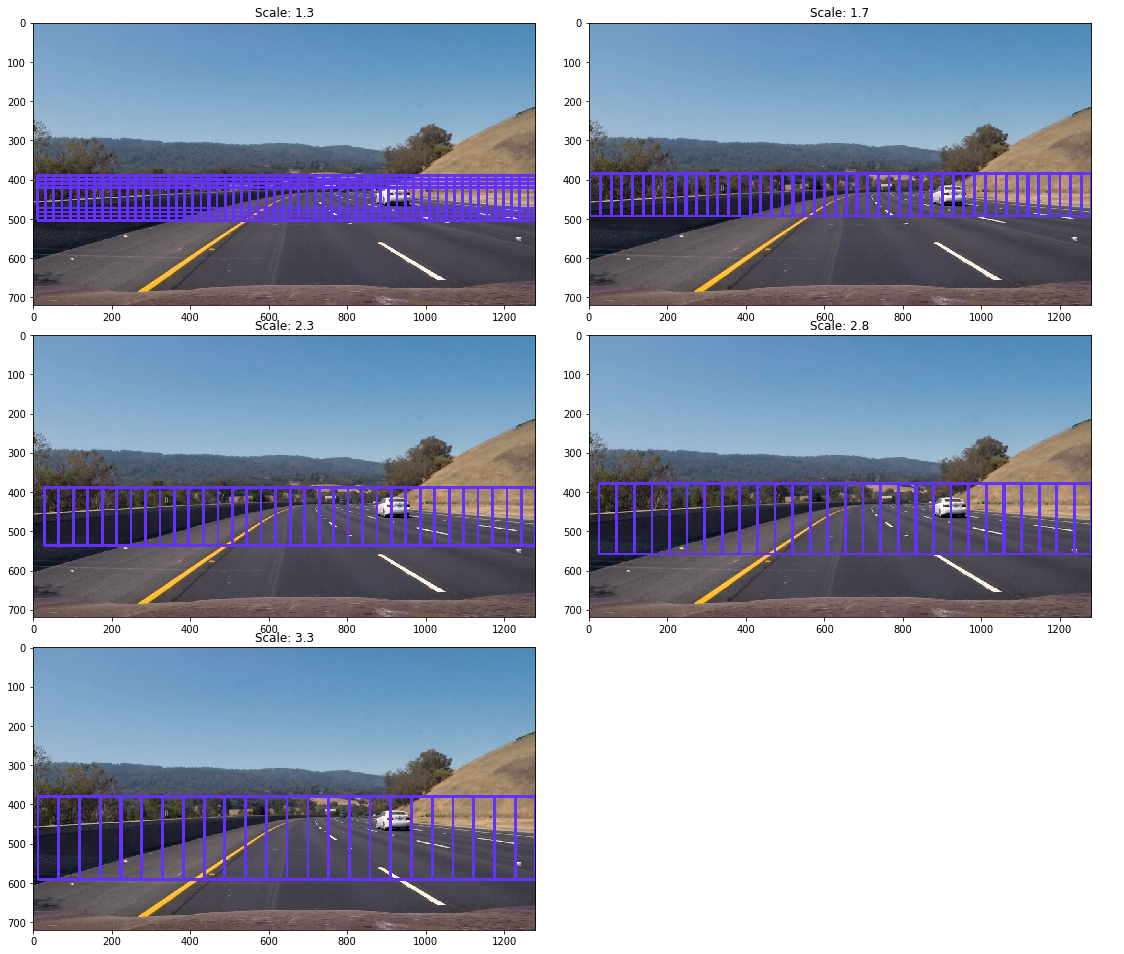

In [2]:
import matplotlib.image as mpimg

window = 64
pix_per_cell = 8
cell_per_block = 2
scales = [1.3, 1.7, 2.3, 2.8, 3.3]
y_start_stop = [(390, 480), (385, 480), (390, 470), (380, 450), (380, 450)]
num_windows = len(scales)
cells_per_step = [(2,1), (2,4), (2,4), (2,6), (2,6)]
assert(len(scales) == len(y_start_stop))

img = mpimg.imread('./test_images/test3.jpg')
windows = []
for i in range(num_windows):
    win = setWindows(img, y_start_stop[i][0], y_start_stop[i][1], 
                    scales[i], window, pix_per_cell, cell_per_block, cells_per_step[i])
    windows.append(win)

fig, axes = plt.subplots(-(-num_windows // 2), 2, figsize=(38, 14))
axes = axes.flatten()
fig.tight_layout()

for i in range(num_windows):
    axes[i].imshow(windows[i])
    axes[i].set_title("Scale: {}".format(scales[i], fontsize=24))
    
for ax in axes[num_windows:]:
    ax.axis("off")

plt.subplots_adjust(left=0., right=0.4, top=0.9, bottom=0.)
plt.show()


# Testing Window-drawing Pipeline

Total number of windows: 353


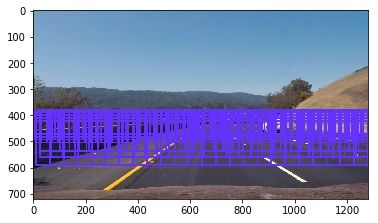

In [3]:
from windows import Windows

w = Windows(img.shape)

draw_image = np.copy(img)

for coor in w.windows:
    cv2.rectangle(draw_image ,coor[0],coor[1],(100,50,255),6) 
print("Total number of windows:", len(w.windows))
plt.imshow(draw_image)
plt.show()

# Detecting Vehicles on Test Images

/Users/jianjieliu/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jianjieliu/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


['./test_images/test1.jpg', './test_images/test2.jpg', './test_images/test3.jpg', './test_images/test4.jpg', './test_images/test5.jpg', './test_images/test6.jpg']
Time take to process image: 3.97


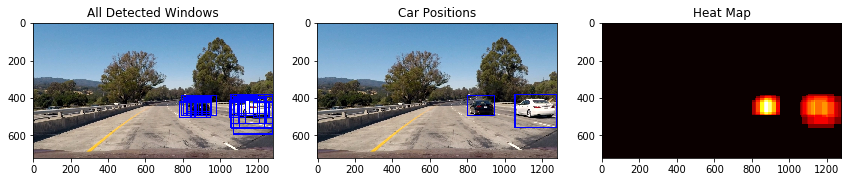

Time take to process image: 4.1


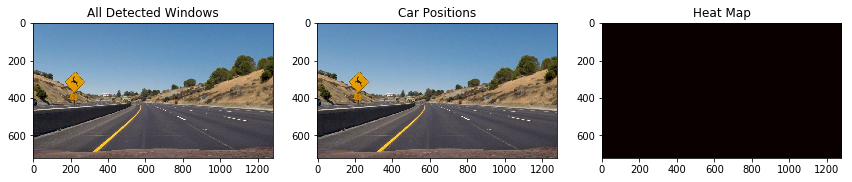

Time take to process image: 5.59


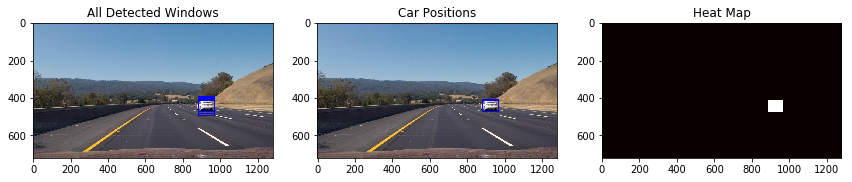

Time take to process image: 4.07


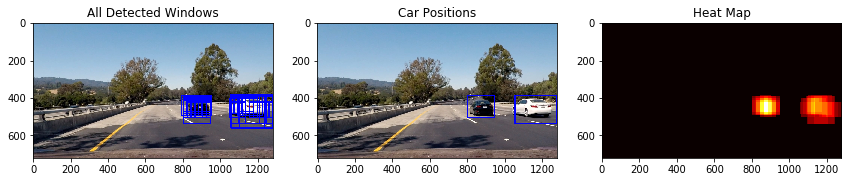

Time take to process image: 4.13


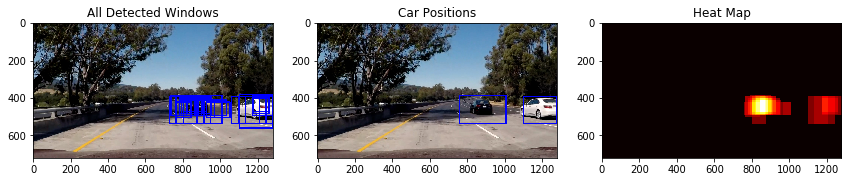

Time take to process image: 3.55


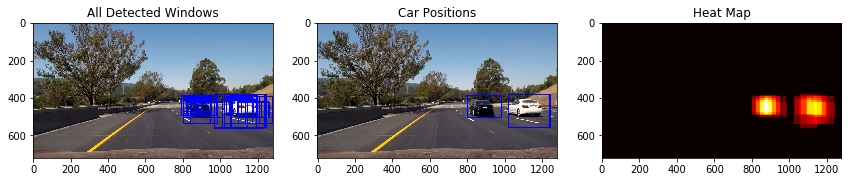

In [4]:
import glob, time
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from detect import detect_vehicle
from lesson_functions import draw_boxes

test_img = glob.glob('./test_images/*jpg')
print(test_img)
for img_name in test_img:
    image = mpimg.imread(img_name)

    t_start = time.time()
    draw_img, heatmap, hot_windows = detect_vehicle(image, show_heat=True)               
    t_end = time.time()
    print("Time take to process image:", round(t_end - t_start, 2))
    window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)                 

    fig = plt.figure(figsize=(12,6))
    plt.subplot(131)
    plt.imshow(window_img)
    plt.title('All Detected Windows')
    plt.subplot(132)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(133)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()

# Run Vehicle Detection Through Video

In [1]:
from moviepy.editor import VideoFileClip
from detect import detect_vehicle

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(detect_vehicle)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [01:26<00:02,  2.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 1min 24s, sys: 863 ms, total: 1min 25s
Wall time: 1min 28s


In [2]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [1]:
from moviepy.editor import VideoFileClip
from detect import detect_vehicle

test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(detect_vehicle)
%time clip_test_out.write_videofile(test_out_file, audio=False, fps=20)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1008/1009 [56:47<00:03,  3.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 56min 8s, sys: 22 s, total: 56min 30s
Wall time: 56min 49s


In [2]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))